# Lab 5: The DFT and FFT

In the last lab, we explored the Discrete-Time Fourier Transform (DTFT) and the frequency response of LSI systems. However, we know that it is impossible to hold an entire DTFT in computer memory since the DTFT of a signal has infinitely many points! We will discuss the Discrete Fourier Transform (DFT) and Fast Fourier Transform (FFT) in this lab as the practical implementations of the DTFT and consider some of the limitations and considerations when using the DFT.

## Discrete Fourier Transform

The Discrete Fourier Transform (DFT) is the discretized version of the DTFT. Sounds weird, right? Isn't the DTFT already discrete? It's in the name! But recall that the DTFT is a continuous function: it has infinitely many points. The DFT is just a resampling of the DTFT. In other words, the DFT picks a finite number of equally spaced points in the DTFT for representation.

More concretely, the DFT is computed as follows: 

$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j\frac{2\pi k}{N}n}, \quad 0\leq k\leq N-1.
$$
And the inverse DFT is given by:

$$
x[n] = \frac{1}{N}\sum_{k=0}^{N-1}X[k]e^{j\frac{2\pi k}{N}n}, \quad 0\leq n\leq N-1
$$
The DFT has $N$ "frequency bins" differentiated by our frequency index $k$. These are the samples we take from the DTFT. Perhaps a more intuitive formulation of the DTFT makes these bins more obvious:

$$
\omega_k = \frac{2\pi k}{N},
$$

$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j\omega_k n}, \quad 0\leq k\leq N-1.
$$

This representation explicitly shows that we try to capture $N$ equally spaced frequencies between 0 to $2\pi$ (same as $-\pi$ to $\pi$ by periodicity of DTFT) with the DFT.

### The Linear Algebra Intuition

The DFT gives an important insight into how we can use linear algebra or vectorize our systems to perform common signal processing operations. Consider our second formulation of the DFT. Suppose we fix $k$ to be one value $k_0$. The second formulation tells us that

$$
X[k_0] = \sum_{n=0}^{N-1}x[n]e^{-j\omega_{k_0} n}.
$$

There is helpful notation that can be introduced here using something call the "twiddle factor" (great name, right?). Different conventions exist for the twiddle factor, but we will opt for the one most consistent with your ECE 310 textbook. Consider the following notation for the twiddle factor $W$:

$$
W = e^{-j2\pi}
$$

$$
W_N = e^{-j\frac{2\pi}{N}}
$$

$$
W_N^{k} = e^{-j\frac{2\pi k}{N}}
$$

If we return to our expression for $X[k_0]$, we see that all we are doing at frequency $\omega_{k_0}$ is summing the product of each entry in the signal and some complex exponential. This is the same thing as taking an inner product (dot product) between the signal and the complex exponential rotating at frequency $w_{k_0}$! Thus,

$$
e^{-j\omega_{k_0}n} = [e^{-j\omega_{k_0}*(0)},e^{-j\omega_{k_0}*(1)},\ldots,e^{-j\omega_{k_0}*(N-1)}] = [W_N^{k_0*0},W_N^{k_0*1},W_N^{k_0*2},\ldots,W_N^{k_0*(N-1)}]
$$

$$
X[k_0] = \langle W_N^{-k_0n},x[n] \rangle.
$$

Note that when we take the inner product over complex numbers, we conjugate transpose the first term by convention. For example, $\langle x,y\rangle = x^*y$, where $x^*$ is the transpose of $x$ and each element is complex conjugated. Thus,
$$
X[k_0] = \langle W_N^{-k_0n},x[n] \rangle = \sum_{i=0}^{N-1}W_N^{k_0i}x[i]
$$
as desired.

Now, recall that if the dot product between two vectors is large, they are similar. The same is true here! For each frequency, we take the dot product between our signal and a vector represented by a complex exponential at a fixed frquency. The result tells us how much that fixed frequency is found in our signal. Wow. We can take one final step to make the entire DFT a matrix-vector product:

$$
X[k] = \mathbf{W}\vec{x}
$$

$$
X[k] = \underbrace{\begin{bmatrix}
W_N^0 & W_N^0 & \cdots & W_N^0 \\
W_N^0 & W_N^1 & \cdots & W_N^{N-1}\\
\vdots &  \vdots & \ddots & \vdots\\
W_N^0 & W_N^{N-1} & \cdots & W_N^{(N-1)(N-1)}
\end{bmatrix}}_{\mathbf{W}}
\underbrace{\begin{bmatrix}
x[0] \\
x[1] \\
\vdots \\
x[N-1] \\
\end{bmatrix}}_{\vec{x}} = 
\begin{bmatrix}
\langle W_N^{-0*n},\vec{x} \rangle\\
\langle W_N^{-1*n},\vec{x} \rangle\\
\vdots\\
\langle W_N^{-k*n},\vec{x} \rangle\\
\vdots\\
\langle W_N^{-(N-1)*n},\vec{x} \rangle\\
\end{bmatrix}
$$

In the above $\textbf{W}$ matrix, each row represents a frequency vector. Thus, row $k$ represents the frequency vector for $\omega_k$. This kind of intuition is powerful in signal processing. If this confuses or (hopefully not) scares you, do not worry! It takes time to be comfortable with combining signal processing and linear algebra. Read the above explanation a couple times, ask your TA questions, check out your textbook's coverage of this, or hang out with some friends and chat about it!

### And finally the FFT!

We will not focus on the math of the FFT since you have covered it in ECE 310. For now, we should acknowledge the computational efficiency of the FFT. The previous two views of the DFT we have discussed - summation and vectorized versions - all require $\mathcal{O}(n^2)$ multiply-add operations. Conversely, the FFT is a divide-and-conquer algorithm that can perform the same computation in $\mathcal{O}(n\log n)$ multiply-add operations. Keep this in mind when completing Excercise 1.

In [72]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio
from skimage.io import imread
from scipy import signal
from scipy.io import wavfile
from linear_convolution import linear_convolution
import math

%matplotlib inline

## Excercise 1: Implementing the DFT

There are multiple different implementations we can use to represent the DFT. In this exercise, you will compare three ways to compute the DFT. 

a. First, fill in the below function $\textrm{dfl_dft()}$ to create a double for-loop implementation of the DFT.

b. Next, fill in $\textrm{dft_matrix()}$ and $\textrm{vectorized_dft()}$ to create a vectorized implementation of the DFT.

c. Finally, let's test our double for-loop and vectorized methods against the $\textrm{np.fft.fft()}$ implementation. Run the provided code that benchmarks the running time of eahc method and verifies if your methods accurately compute the DFT of a randomly generated signal. Note that we do not time the time to build the "W" matrix since this could be precomputed in a practical context. For example, if we compute 1000 length-500 DFTs, we would only need to construct "W" once. Comment on the results. Which method is fastest? Slowest? Why? Does anything surprise you?

In [73]:
#Function to complete for 1.a
def dfl_dft(x):
    N = len(x)
    dft = np.empty(N,dtype=np.complex64)
    #for loop to iterate over 'k'
    for k in range(0,N):      #for loop to iterate over 'n'
        w = (2*np.pi*k)/N
        dft[k] = 0.+0.j
        for z in range(0,N):
            dft[k] += (x[z] * np.exp(-1.j*w*z))
    return dft

#Functions to complete for 1.b
def dft_matrix(N):
    W = np.empty((N,N),dtype=np.complex64)
    #fill in W however you see fit!
    for i in range(0,N):
        for j in range(0,N):
            W[i][j] = window(i*j,N)
    return W

def window(k,N):
    W = np.exp((-1.j*2*np.pi*k)/N)
    return W

def vectorized_dft(W,x):
    #this should only take one line...
    #refer to the above math if you are unsure!
    dft = np.matmul(W,x)
    return dft

In [116]:
#Provided code for 1.c
#Generate test signal
N = 500
x = np.random.uniform(size=N)
#x = np.ones(500)

#Test double for-loop implementation
print('Double For Loop Time:')
%timeit dfl_dft(x)
print('')

#Test vectorized implementation
#don't time W matrix construction since this is precomputation that could be practically stored
W = dft_matrix(N)
print('Vectorized Time')
%timeit vectorized_dft(W,x)
print('')

#Test numpy's fft implementation
print('Numpy Time')
%timeit np.fft.fft(x)
print('')

#for i in range(3):
#    print("DFL:",dfl_dft(x)[i])
#    print("Vect:",vectorized_dft(W,x)[i])
#    print("FFT:",np.fft.fft(x)[i])

#Test if results are equivalent
print('Double for-loop and numpy fft are equivalent:',np.allclose(dfl_dft(x),np.fft.fft(x)))
print('Vectorized DFT and numpy fft are equivalent:',np.allclose(vectorized_dft(W,x),np.fft.fft(x)))

Double For Loop Time:
2.83 s ± 86.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Vectorized Time
4.37 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Numpy Time
5.72 µs ± 516 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Double for-loop and numpy fft are equivalent: True
Vectorized DFT and numpy fft are equivalent: True


__Answer for Part 1.c:__ Numpy's FFT is the fastest at 6.31 µs, the Vectorized time is second fasest at 4.3 ms, and the Double For-Loop is the slowest method at 2.76 s.  I believe this is because Numpy's FFT is designed to be efficient and fast. The vectorized method has a pre-computed twiddle factor matrix, so it will just be the time it takes to multiply two matrices.  The double for-loop is rightfully the slowest since it must go through and calculate each sum for each k value in the DFT.

## Windowing and Zero-Padding

We will now briefly discuss the motivation for windowing and zero-padding. Exercises 2 and 3 will demonstrate and reinforce this theory.

Recall that the DFT works under the practical assumption that we only have a finite number of samples for our signal. Unlike the DTFT which uses infinitely points, we must use a finite collection to capture the frequency content of our signal. In the simplest case, we use a rectangular window that removes the $N$ points we will inspect for the DFT. Mathematically, we have,

$$
x_{\textrm{windowed}} = x[n](u[n-n_0]-u[n-(n_0+N)]),
$$

where $n_0$ is the start-point of our signal's window. This window signal is the same as a shifted rectangle function. We see that windowing is multiplying in the time domain, which is convolution in the frequency domain. Thus, for a window function $w[n]$,

$$
x[n]w[n] \leftrightarrow \frac{1}{2\pi}X(\omega) * W(\omega).
$$

Exercise 2 will explore the consequences of using the rectangular window and what other windows may be used. Next, let's explain the use of zero-padding. When zero-padding a signal, we are simply appending some number of zeros to the end of the original signal. What effect does this have? Suppose I have original signal $x[n]$ of length $N$ and a zero-padded signal $x_{zp}[n]$ of length $M>N$.

$$
X[k] = \sum_{n=0}^{N-1}x[n]e^{-j\frac{2\pi k}{N}n},\quad 0\leq k\leq N-1
$$

$$
X_{zp}[k] = \sum_{n=0}^{M-1}x_{zp}[n]e^{-j\frac{2\pi k}{M}n},\quad \leq k\leq M-1
$$

$$
x_{zp}[n] = 0\textrm{ for all } n \geq N \implies X_{zp}[k] = \sum_{n=0}^{N-1}x_{zp}[n]e^{-j\frac{2\pi k}{M}n}
$$

$$
X_{zp}[k] = \sum_{n=0}^{N-1}x[n]e^{-j\frac{2\pi k}{M}n},\quad 0\leq n\leq M-1
$$

We see that the zero-padded signal's DFT will use the exact same signal values, and thus have the exact same frequency content. The difference is that the spacing of our frequency sampling is tighter!

$$
\frac{2\pi}{M} < \frac{2\pi}{N}
$$

Consequently, we add no "information" to our signal (only zeros) and gain higher frequency resolution at the cost of storing some zeros. This is what implictly happens when you use $\textrm{np.fft.fft()}$ or $\textrm{np.fft.rfft()}$ and specify a number of points greater than the length of the signal. Exercise 3 will give a brief example of how zero-padding can affect our ability to resolve different frequency components or notes in audio.

## Excercise 2: Windowing Effects

In this exercise, we want to investigate the effects of different windowing methods. When we are computing the DFT of a segment of a signal, it is assumed that there is periodic extension of the signal (more on this in Exercise 5 and related background). If the segment precisely captures full cycles of all the frequencies, then there will be no problem since we have no periodic interruptions. However, if the segment does not capture full cycles of some frequencies, then there will be periodic interruptions in our true frequencies. This problem is reffered to as spectral leakage. This is illustrated in the example below:

Suppose that we are sampling a single sine wave, we have two cases:
1. We have full cycles
2. We have only partial cycles

Text(0.5,0,'$\\omega$')

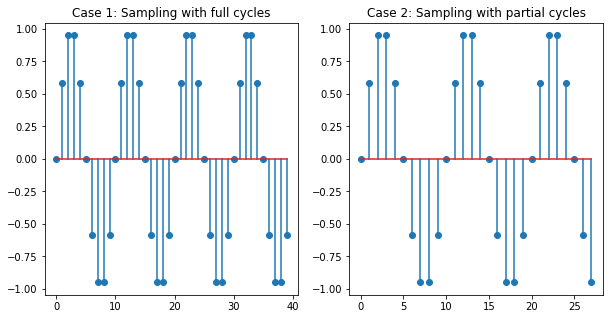

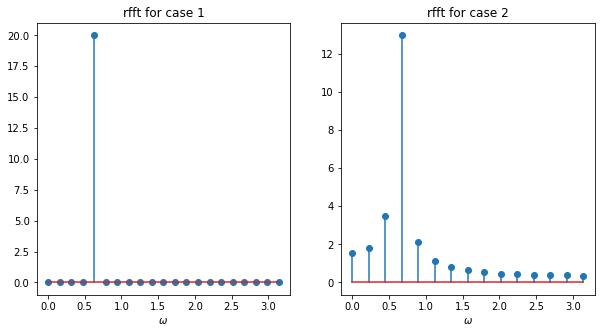

In [138]:
# Suppose that we are sampling a 10 Hz sine wave
Fs = 100 # 100Hz sampling rate

# case 1 
N1 = 40 # Suppose we have 40 sample points
n1 = np.arange(N1) 
x1 = np.sin(2*np.pi*10*n1/100)  
x1_fft = np.fft.rfft(x1)
omeg_1 = np.linspace(0,np.pi,len(x1_fft))

# case 2
N2 = 28 # Suppose we have 28 sample points
n2 = np.arange(N2) 
x2 = np.sin(2*np.pi*10*n2/100)  
x2_fft = np.fft.rfft(x2)
omeg_2 = np.linspace(0,np.pi,len(x2_fft))

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.stem(n1, x1)
plt.title('Case 1: Sampling with full cycles')
plt.subplot(122)
plt.stem(n2, x2)
plt.title('Case 2: Sampling with partial cycles')

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.stem(omeg_1, abs(x1_fft))
plt.title('rfft for case 1')
plt.xlabel('$\omega$')
plt.subplot(122)
plt.stem(omeg_2, abs(x2_fft))
plt.title('rfft for case 2')
plt.xlabel('$\omega$')

From the above example, we can see that although we are sampling the same sine wave signal, we obtain different frequency spectra for the two cases. The mismatch in sampling length for case 2 leads to the spectral leakage witnessed above. The mismatch creates a sharp discontinuity between the periodically extended copies of our finite window. This introduces other frequencies into the spectrum to compensate for this discontinuity. 

Therefore, we would like windowing to smooth out the discontinuity and, therefore, decrease the effect of spectral leakage.

What kind of windows may we consider then? Well, we have different windows for different situations. Here are the examples we want to investigate:

1. Rectangular Window (just removing the segment of interest)
2. Triangular Window
3. Hanning Window
4. Hamming Window
5. Kaiser Window ($\beta=3$)

a. Give two plots for each of the above windows. The first plot is the time domain representation of the window, and the other is the magnitude spectrum of the window. Below we have given you the codes for the rectangular window. Do the same thing for the other windows! $\textbf{It will probably be a good idea to put all the windows' FFT spectra on a SINGLE figure}$. Please plot the spectrum for each window using a log-scale. We have provided a convenience function that converts to the log scale for you. Comment on the spectra of each window. Specifically, how do the main lobe widths and side lobe heights differ? (Hint: the ``scipy.signal`` package has nice functions for each of these windows)

b. Apply the 5 windows to the sine wave signal we sampled with partial cycles (the case 2 signal) and plot the magnitude spectrum of each windowed result. We notice that multiplication in the time domain is equal to convolution in the frequency domain. Thererfore, having different frequency responses, different windows will give us outputs that have different frequency spectra. Is the problem of spectral leakage smoothed out by the windows? Relate the windowed signal spectra to the results we see in part 2.a.

C:\Users\Damian\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


(-5, 15)

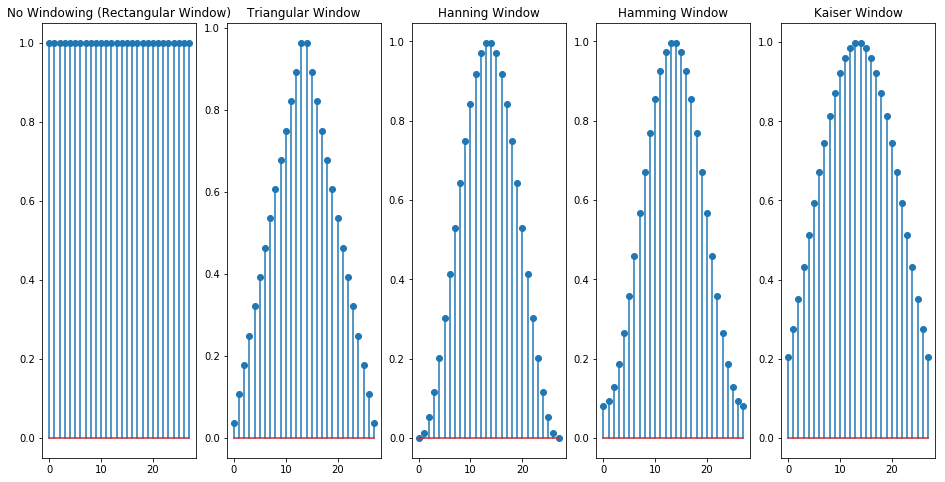

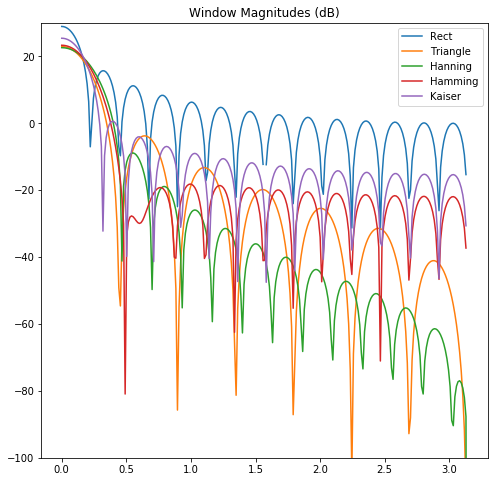

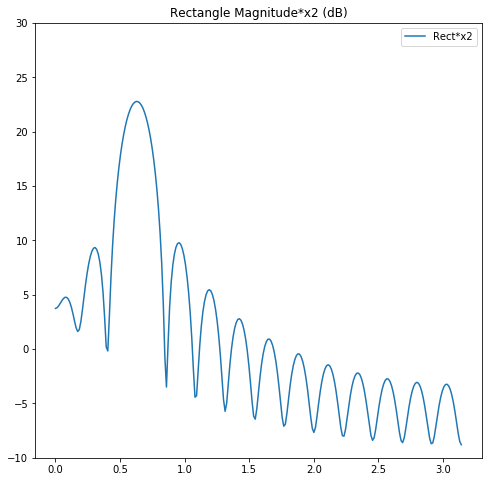

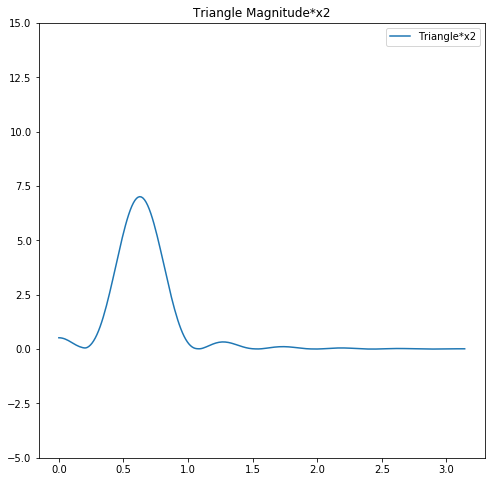

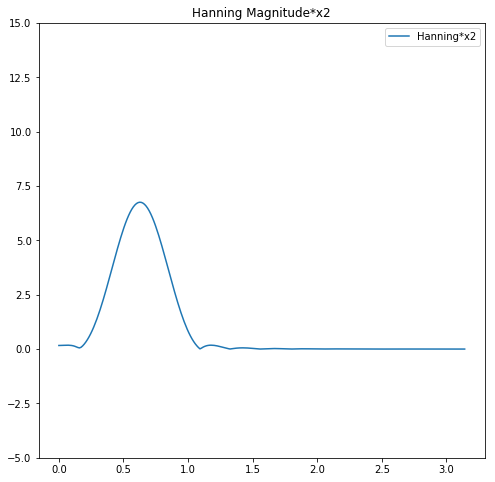

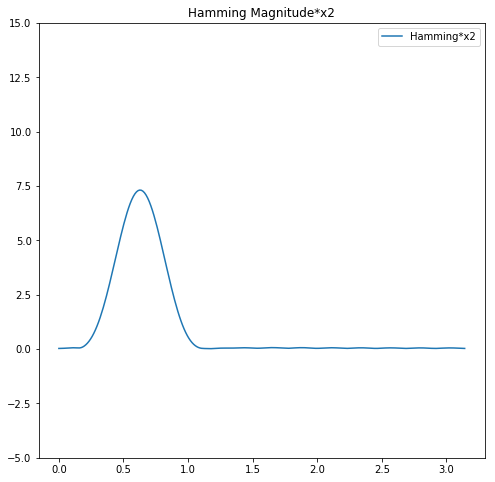

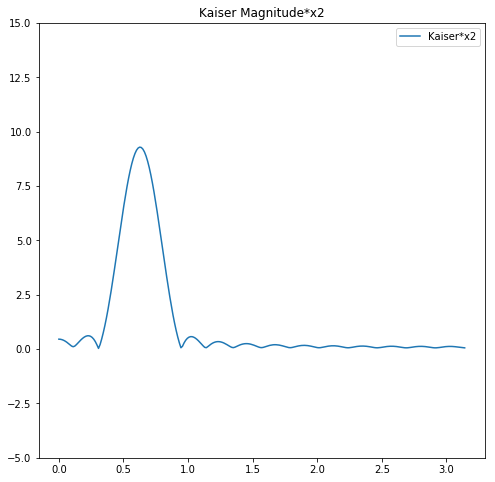

In [142]:
N = 28 # number of points we use to create our window
n = np.arange(N)

def sig2db(mag_spec):    # quick function for converting to dB
    return 20*np.log10(mag_spec)

#Code for 2.a:

# Rectangular window

wind1 = np.array([1 for i in n])
fft_wind1 = np.fft.rfft(wind1, n = 512) #take 512 point DFT
omega = np.linspace(0,np.pi,len(fft_wind1))
# Insert your code here!
# Triangular window
triangle = signal.windows.triang(28)
fft_tri = np.fft.rfft(triangle, n = 512)
omegaTri = np.linspace(0,np.pi,len(fft_tri))
# Hanning window
hanning = signal.windows.hann(28)
fft_hann = np.fft.rfft(hanning, n = 512)
omegaHan = np.linspace(0,np.pi,len(fft_hann))
# Hamming window
hamming = signal.windows.hamming(28)
fft_hamm = np.fft.rfft(hamming, n = 512)
omegaHam = np.linspace(0,np.pi,len(fft_hamm))
# Kaiser window
kaiser = signal.windows.kaiser(28, 3)
fft_kai = np.fft.rfft(kaiser, n = 512)
omegaKai = np.linspace(0,np.pi,len(fft_kai))

plt.figure(figsize =(16,8))
plt.subplot(151)
plt.stem(n, wind1)
plt.title('No Windowing (Rectangular Window)')
#Finish time-domain suplots for each window here
plt.subplot(152)
plt.stem(n, triangle)
plt.title('Triangular Window')

plt.subplot(153)
plt.stem(n, hanning)
plt.title('Hanning Window')

plt.subplot(154)
plt.stem(n, hamming)
plt.title('Hamming Window')

plt.subplot(155)
plt.stem(n, kaiser)
plt.title('Kaiser Window')


plt.figure(figsize =(8,8))
plt.plot(omega,sig2db(abs(fft_wind1)), label="Rect")
#Place remaining magnitude spectrum plots here:
plt.plot(omegaTri,sig2db(abs(fft_tri)), label="Triangle")

plt.plot(omegaHan,sig2db(abs(fft_hann)), label="Hanning")

plt.plot(omegaHam,sig2db(abs(fft_hamm)), label="Hamming")

plt.plot(omegaKai,sig2db(abs(fft_kai)), label="Kaiser")

plt.title('Window Magnitudes (dB)')
plt.legend()
plt.ylim([-100, 30])

#Code for 2.b:

#Apply each window to the x2 signal
res_rect = x2*wind1
res_triang = x2*triangle
res_hann = x2*hanning
res_hamm = x2*hamming
res_kai = x2*kaiser
fft_rect2 = np.fft.rfft(res_rect, n = 512)
fft_tri2 = np.fft.rfft(res_triang, n = 512)
fft_hann2 = np.fft.rfft(res_hann, n = 512)
fft_hamm2 = np.fft.rfft(res_hamm, n = 512)
fft_kai2 = np.fft.rfft(res_kai, n = 512)
omegaRect2 = np.linspace(0,np.pi,len(fft_rect2))
omegaTri2 = np.linspace(0,np.pi,len(fft_tri2))
omegaHann2 = np.linspace(0,np.pi,len(fft_hann2))
omegaHamm2 = np.linspace(0,np.pi,len(fft_hamm2))
omegaKai2 = np.linspace(0,np.pi,len(fft_kai2))

plt.figure(figsize =(8,8))
#Plot each windowed signal's magnitude spectrum on separate subplots
plt.plot(omegaRect2,sig2db(abs(fft_rect2)), label="Rect*x2")
plt.title('Rectangle Magnitude*x2 (dB)')
plt.legend()
plt.ylim([-10, 30])
#Place remaining magnitude spectrum plots here:
plt.figure(figsize =(8,8))
plt.plot(omegaTri2,(abs(fft_tri2)), label="Triangle*x2")
plt.title('Triangle Magnitude*x2')
plt.legend()
plt.ylim([-5, 15])

plt.figure(figsize =(8,8))
plt.plot(omegaHann2,(abs(fft_hann2)), label="Hanning*x2")
plt.title('Hanning Magnitude*x2')
plt.legend()
plt.ylim([-5, 15])

plt.figure(figsize =(8,8))
plt.plot(omegaHamm2,(abs(fft_hamm2)), label="Hamming*x2")
plt.title('Hamming Magnitude*x2')
plt.legend()
plt.ylim([-5, 15])

plt.figure(figsize =(8,8))
plt.plot(omegaKai2,(abs(fft_kai2)), label="Kaiser*x2")
plt.title('Kaiser Magnitude*x2')
plt.legend()
plt.ylim([-5, 15])


__Comments for part 2.a:__ The rectangular window has the smallest main lobe size; the Kaiser window has the second smallest; Triangular, Hanning, and Hamming windows have similar main lobe sizes.  All of the them have similar side lobe heights besides the triangular window, which has a side lobe height double of the others.  Most of the side lobes stay at a constant decibel value, but the triangle window's and the Hanning window's side lobes' decibel values decrease as frequency increases


__Comments for part 2.b:__ The Hamming window seems to smooth out the frequency leakage the most, followed in order by Hanning, triangular, Kaiser, then rectangular.  This relates to the window having a large main lobe width and a large side lobe height that is decreasing in dB values, although the large main lobe seems to be the most important feature.



## Exercise 3: Zero-Padding00000

Now let's consider the problem of examining frequency content in a piece of music and how zero-padding affects our ability to do so. Load and listen to the below audio clip.

In [101]:
fs, music_stereo = wavfile.read('Hallelujah_16k.wav') # Import the sound file
music_mono = music_stereo[:,0] # To obtain mono sound track
Audio(music_mono, rate = fs)

C:\Users\Damian\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


There's a lot going on for such a short audio clip! What if we only look at the frequency content present in the first 256 samples?

129 129


Text(0,0.5,'Magnitude Response')

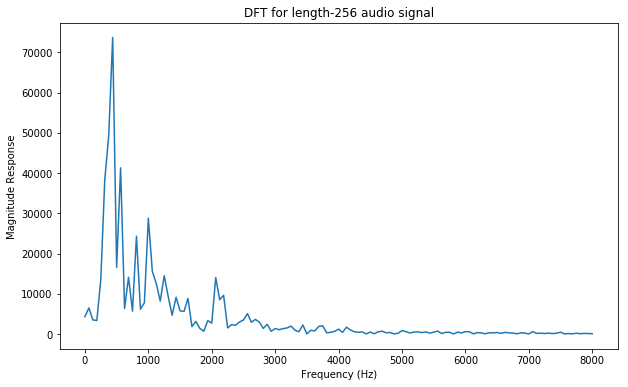

In [109]:
N = 256
music_mono_short = music_mono[:N] # if we are only given the first 256 samples
fft_short = np.fft.rfft(music_mono_short)
freq = [2*np.pi*k/N * (fs / (2*np.pi))for k in range(N) if 2*np.pi*k/N <= np.pi] 
print(len(fft_short), len(freq))
plt.figure(figsize =(10,6))
plt.plot(freq, abs(fft_short))
plt.title('DFT for length-256 audio signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude Response')

a. Zero-pad our length-256 clip to length 2048. Plot the new magnitude spectrum of our zero-padded signal.

b. Comment on the differences (quantitative or qualitative) that you observe. Has zero-padding improved our ability to distinguish different frequencies?

c. Now, if we are only given the first 16 samples instead of 256. Do you think zero-padding to length 2048 will also give us the ability to identify all the peaks like in the previous case? Why or why not?

Text(0,0.5,'Magnitude Response')

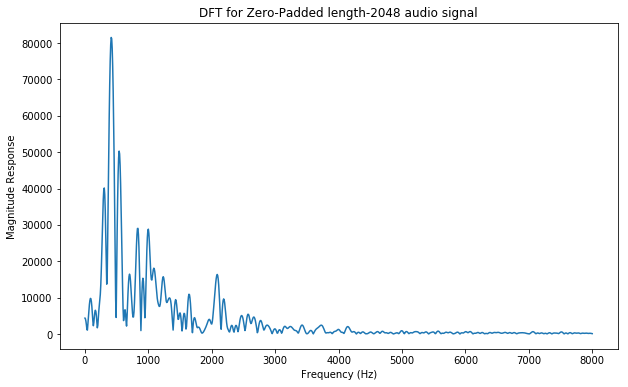

In [110]:
# Code for 3a:
M=2048
#music_mono_short0 = music_mono_short
zero = np.zeros(1792)
music_mono_short0 = np.append(music_mono_short, zero)
#print(music_mono_short.shape, music_mono_short0.shape)
fft_short0 = np.fft.rfft(music_mono_short0)
freq0 = [2*np.pi*k/M * (fs / (2*np.pi))for k in range(M) if 2*np.pi*k/M <= np.pi] 
#print(len(fft_short0), len(freq0))
plt.figure(figsize =(10,6))
plt.plot(freq0, abs(fft_short0))
plt.title('DFT for Zero-Padded length-2048 audio signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude Response')

#N = 16
#music_mono_short = music_mono[:N] # if we are only given the first 256 samples
#fft_short = np.fft.rfft(music_mono_short)
#freq = [2*np.pi*k/N * (fs / (2*np.pi))for k in range(N) if 2*np.pi*k/N <= np.pi] 
#print(len(fft_short), len(freq))
#plt.figure(figsize =(10,6))
#plt.plot(freq, abs(fft_short))
#plt.title('DFT for length-16 audio signal')
#plt.xlabel('Frequency (Hz)')
#plt.ylabel('Magnitude Response')
#M=2048
##music_mono_short0 = music_mono_short
#zero = np.zeros(2032)
#music_mono_short1 = np.append(music_mono_short, zero)
##print(music_mono_short.shape, music_mono_short0.shape)
#fft_short1 = np.fft.rfft(music_mono_short1)
#freq1 = [2*np.pi*k/M * (fs / (2*np.pi))for k in range(M) if 2*np.pi*k/M <= np.pi] 
#print(len(fft_short1), len(freq1))
#plt.figure(figsize =(10,6))
#plt.plot(freq1, abs(fft_short1))
#plt.title('DFT for Zero-Padded length-2048 audio signal')
#plt.xlabel('Frequency (Hz)')
#plt.ylabel('Magnitude Response')

__Comments for 3b:__ Yes, zero-padding has revealed more distinguishable frequencies.


__Comments for 3c:__ We should still be able to improve our ability to distinguish frequencies, although we should not be able to identify all the peaks as we did in the previous part.  This is because we are zero-extending only 16 data points, not 256. 



## Exercise 4: Spectrograms

Now let's look at the spectrogram for an audio signal. A spectrogram can be thought of as a two-dimensional signal with both time and frequency axes. Thus, the value of a spectrogram at a particular pair of time and frequency indicates how much we see that frequency at the given time. Let visualize some examples to make this more concrete. Specifically, we have three audio files that contain three different speech sounds or utterances, the vowel "a" and the two consonants "r" and "b". Listen to each uttereance and look at the associated spectrograms plotted below.

In [88]:
fs_a, vowel_a = wavfile.read('a.wav') 
fs_r, cons_r = wavfile.read('r.wav') 
fs_b, cons_b = wavfile.read('b.wav') 

In [89]:
Audio(vowel_a, rate = fs_a)

In [90]:
Audio(cons_r, rate = fs_r)

In [91]:
Audio(cons_b, rate = fs_b)

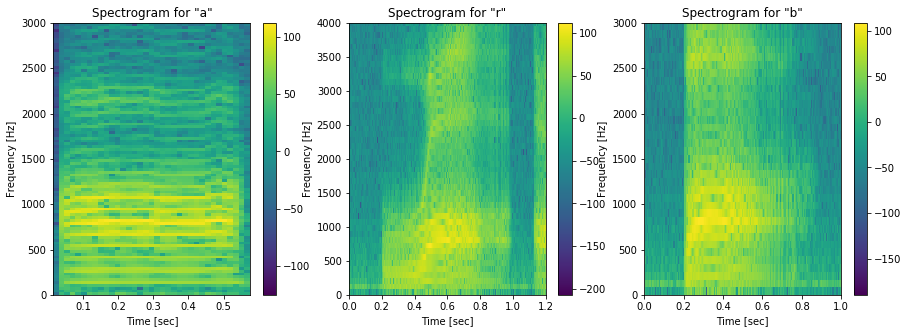

In [92]:
nfft = 512
f_a, t_a, S_a = signal.spectrogram(vowel_a, fs_a, nperseg = nfft, noverlap = int(nfft/2), nfft = nfft)
f_r, t_r, S_r = signal.spectrogram(cons_r, fs_r, nperseg = nfft, noverlap = int(nfft/2), nfft = nfft)
f_b, t_b, S_b = signal.spectrogram(cons_b, fs_b, nperseg = nfft, noverlap = int(nfft/2), nfft = nfft)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.pcolormesh(t_a, f_a, sig2db(S_a))
plt.title('Spectrogram for "a"')
plt.ylim([0, 3000])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.subplot(132)
plt.pcolormesh(t_r, f_r, sig2db(S_r))
plt.title('Spectrogram for "r"')
plt.ylim([0, 4000])
plt.xlim([0, 1.2])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.subplot(133)
plt.pcolormesh(t_b, f_b, sig2db(S_b))
plt.title('Spectrogram for "b"')
plt.ylim([0, 3000])
plt.xlim([0, 1])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()

a. Comment on the differences in the the above spectrograms. Which utterances have higher frequency content? Which have lower frequency content?

b. We have included a sound file ``word.wav`` in the lab folder. This sound file contains a "mysterious" word spoken by someone. (The word remains mysterious if you do not listen to the file!). Import the sound file and plot its spectrogram. Refer to the above spectrogram examples and the $\textrm{signal.spectrogram}$ documentation if you are unsure how to do this.

c. We know that this word contains the two consonants "r" and "b". From the example spectrograms provided above, can you tell where these consonants appear in the mysterious word's spectrogram (i.e. what time do they start)?

C:\Users\Damian\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


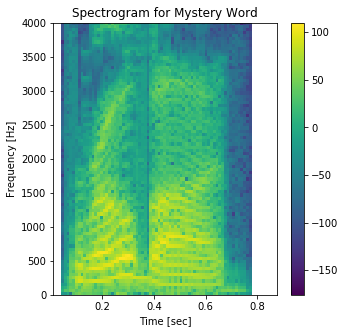

In [98]:
#Code for 4.b here:
fs_word, word = wavfile.read('word.wav')
f_word, t_word, S_word = signal.spectrogram(word, fs_word, nperseg = nfft, noverlap = int(nfft/2), nfft = nfft)

plt.figure(figsize=(5,5))
plt.pcolormesh(t_word, f_word, sig2db(S_word))
plt.title('Spectrogram for Mystery Word')
plt.ylim([0, 4000])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()

__Comments for 4.a here:__ Vowels seem to have lower frequency contents compared to the higher frequency contents of consonants.


__Comments for 4.c here:__ The 'r' spectogram seems to appear between 0 and 0.3 seconds, and the 'b' spectogram seems to appear between 0.4 and 0.6 seconds.



## Circular Convolution and Related DFT Properties

A key assumption in the computation of the DFT is the periodic extension of the signal in the time domain. This periodicity also relates to the $2\pi$ periodicity of the DTFT and DFT.

$$
x[n] = x[n+N], \quad \forall k
$$

$$
X[k] = X[k+N], \quad \forall k
$$

Please refer to the ECE 310 textbook for further mathematical background here. The important takeaway here is that any shifts in time must be circular. Consequently, the convolution that is induced in the time domain by multiplication in the DFT domain is circular. More concisely, multiplication in the DFT domain is circular convolution in the time domain. Thus, for a signal $x[n]$ and system $h[n]$ with DFTs $X[k]$ and $H[k]$, respectively, we have:

$$
X[k]H[k] \implies \sum_{n = 0}^{N-1}x[m-n]_Nh[m] = \sum_{n=0}^{N-1}x[m]h[m-n]_N,
$$

where $[k]_N \equiv (k \mod N)$. Notice that circular convolution between two sequences produces a very different result from the ordinary linear convolution. Thus, we must be careful to make the circular convolution we perform equivalent to the linear convolution of the two sequences. This will guarantee that multiplying in the DFT domain will produce a result consistent with multiplication in the DTFT domain. How do we accomplish this? With zero-padding!

Recall that the linear convolution between length $L$ and length $M$ sequences lead to a length $L+M-1$ result. Conversely, the circular convolution of these sequences would be of length $\max\{L,M\}$; although, the two sequences are typically the same length. Intuitively, if we want our circular conovlution to be the same as our linear convolution, we should guarantee the result is of length $L+M-1$. And this will work! In order to make our circular convolution equivalent to the linear convolution result, we do the following:

$$
\textrm{length}(x) = L,\quad \textrm{length}(h) = M
$$

$$
x\implies \textrm{pad }M-1\textrm{ zeros}
$$
$$
h\implies \textrm{pad }L-1\textrm{ zeros}.
$$

This procedure will guarantee our convolution is the correct length and will also prevent aliasing due to the circular modulation of the shifting sequence. Now, why are we concerned with using the DFT and bothering with circular convolution? Consider that linearly convolving two sequences requires $\mathcal{O}(n^2)$ multiply-add operations. On the other hand, computing the DFT via the FFT takes $\mathcal{O}(n\log n)$ operations. Thus, if we take the DFT of both our signal and filter, multiply in the DFT domain, and perform the inverse DFT via the IFFT, we will have the following computational complexity:

$$
\mathcal{O}(n\log n) + \mathcal{O}(n\log n) + \mathcal{O}(n) + \mathcal{O}(n\log n) = \mathcal{O}(3n\log n) + \mathcal{O}(n) \implies \mathcal{O}(n\log n).
$$

These computational savings are especially impressive when $n$ becomes large for something like an audio signal. Thus, we can use the DFT to perform fast linear convolution for our LSI systems.

## Exercise 5: Fast Linear Convolution

In this exercise, you will create your own implementation of fast linear convolution via the DFT.  

a. Fill in the function $\textrm{fast_convolution()}$ to implement fast linear convolution via the DFT. Refer to the above background if you need help with the necessary steps. Verify the results of your function against $\textrm{signal.convolve()}$ with the provided sample input and filter by printing the output of your function and $\textrm{signal.convolve()}$. Hint: use $\textrm{np.fft.ifft()}$ to take the inverse DFT.

Next, we want to compare the running time of your fast linear convolution function against regular linear convolution via summation. Unfortunately, numpy and scipy's implementations of convolution via summation are too efficient (likely written in C code via Cython) to be compared against our fast convolution. As such, we have provided a function for you called $\textrm{linear_convolution(x1,x2)}$ that implements convolution by summation in Python. This will be a fairer test of the efficiency of your fast linear convolution function.

We have provided a testing framework that builds a random signal and filter of length $L$, calls your function and the linear convolution function, and outputs the running time.

b. Test the two functions for $L = 2^6$. Report the average running time in the below Markdown cell.

c. Test the two functions for $L = 2^{10}$. Report the average running time.

d. Test the two functions for $L = 2^{14}$. Report the average running time.

e. Comment on the results for each length. How do your results compare to the theoretical background given above?

In [117]:
#Code for 5.a:

#Fill in this function!
def fast_convolution(x,h):
    lenH = len(h)
    lenX = len(x)
    zeroH = np.zeros(lenX-1)
    zeroX = np.zeros(lenH-1)
    y1 = np.append(x,zeroX)
    y2 = np.append(h,zeroH)
    y = np.fft.ifft(np.fft.fft(y1)*np.fft.fft(y2))
    return y

#Test signals
x1 = [1,3,-2,-1]
x2 = [0,2,4,1]

print('Fast Convolution and Linear Convolution are equivalent:',np.allclose(fast_convolution(x1,x2),signal.convolve(x1,x2)))


Fast Convolution and Linear Convolution are equivalent: True


In [119]:
#Testing framework for parts 5.b-5.d:
L = 2**6 #Change this for each part!
M = 2**(10)
N = 2**(14)
x = np.random.uniform(size=L)
h = np.random.uniform(size=L)
print('Regular Linear Convolution Results, L=2^6:')
%timeit linear_convolution(x,h)
print('Fast Linear Convolution Results, L=2^6:')
%timeit fast_convolution(x,h)
print('')
x = np.random.uniform(size=M)
h = np.random.uniform(size=M)
print('Regular Linear Convolution Results, L=2^10:')
%timeit linear_convolution(x,h)
print('Fast Linear Convolution Results, L=2^10:')
%timeit fast_convolution(x,h)
print('')
x = np.random.uniform(size=N)
h = np.random.uniform(size=N)
print('Regular Linear Convolution Results, L=2^12:')
%timeit linear_convolution(x,h)
print('Fast Linear Convolution Results, L=2^12:')
%timeit fast_convolution(x,h)



Regular Linear Convolution Results, L=2^6:
76.9 µs ± 3.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Fast Linear Convolution Results, L=2^6:
88.8 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Regular Linear Convolution Results, L=2^10:
19.3 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Fast Linear Convolution Results, L=2^10:
782 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Regular Linear Convolution Results, L=2^12:
4.76 s ± 356 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Fast Linear Convolution Results, L=2^12:
12.9 ms ± 719 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Comments for 5.e: As the length grows from 2^6 to 2^14, the time for the regular linear convolution takes much longer, whereas the fast convolution takes longer, but not nearly as long as the regular method.  This confirms the theory that the regular linear convolution would take O(n^2) time, but our fast method would take O(n*log(n)) time.


## Exercise 6: Where's Waldo Going?

We will conclude this lab with an interesting (and cute) demonstration of DFT properties. The notion of the DFT is not limited to one-dimensional signals: we may go to arbitrary numbers of dimensions. For this exercise, we will work with the (two-dimensional) DFT of an image. We have provided the DFT of the test image.

a. For this part, we will apply a linear phase to each row of the image's DFT. Mathematically, this means you will multiply each row $r$ in the image's DFT by the following complex number

$$
\large{\textrm{Phase at row }r = e^{-j\frac{2\pi n_0}{R} r}},
$$

where $R$ is the number of rows in the image and $n_0$ is the phase offset we would like. Notice that each row is multiplied by its own constant complex number. This phase scales linearly from row-to-row. Apply linear phase along the rows of the test image for $n_0=100$. Take the inverse two-dimensional DFT of the resulting DFT and plot the real part of the resulting image. (Hint: use $\textrm{np.fft.ifft2()}$ and $\textrm{np.real()}$ here.) 

b. Apply linear phase to each column of the image's DFT for $n_0 = 100$. Take the inverse two-dimensional DFT of the resulting DFT and plot the real part of the resulting image. Note that you should divide by the number of columns in the above complex exponential for this case.

c. Apply linear phase to the rows and columns of the image's DFT. You may apply the phase along the rows then columns or columns then rows. Choose any non-zero offsets for the rows and columns, respectively.

d. Describe what is happening in the previous three parts. Why is this happening? Think about the DFT properties!

C:\Users\Damian\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Damian\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Damian\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Damian\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5,1,'Row then Column Phase Shift')

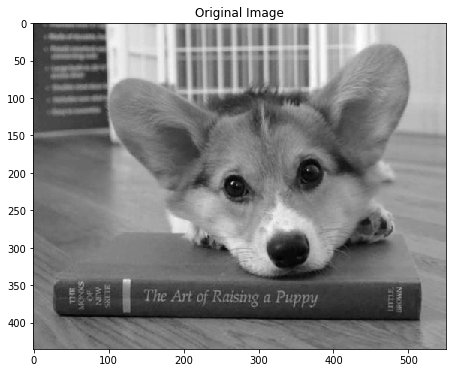

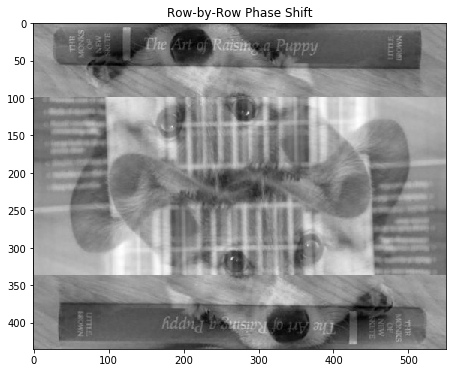

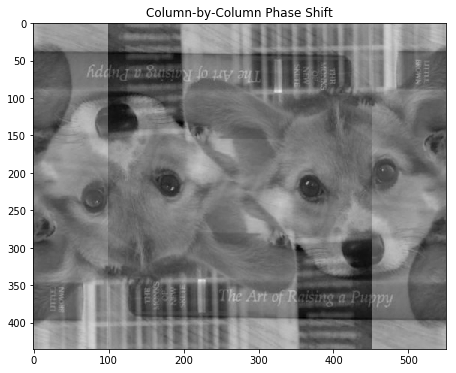

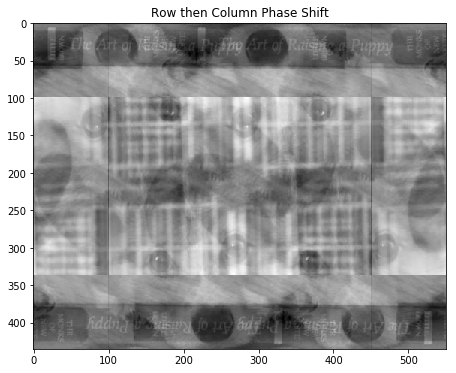

In [136]:
#Load and plot original image
img = imread('test-image.jpg')
n_rows = img.shape[0]
n_cols = img.shape[1]
plt.figure(figsize = (10,6))
plt.imshow(img,'gray')
plt.title('Original Image')

#Compute 2D-DFT
fft2 = np.fft.fft2(img)

#Code for part 6.a:
def phase(r,n,nr):
    output = np.exp(-1.j * 2 * np.pi * n * r / nr)
    return output
dft_rows = fft2.shape[0]
dft_cols = fft2.shape[1]
W = np.empty((dft_rows,dft_cols))
for i in range(dft_rows):
    r = phase(i,100,dft_rows)
    W[i][:] = r*fft2[i][:]
rowresult = np.real(np.fft.ifft2(W))
plt.figure(figsize = (10,6))
plt.imshow(rowresult,'gray')
plt.title('Row-by-Row Phase Shift')

#Code for part 6.b:
X = np.empty((dft_rows,dft_cols))
for i in range(dft_cols):
    r = phase(i,100,dft_cols)
    for j in range(dft_rows):
        X[j][i] = r*fft2[j][i]
colresult = np.real(np.fft.ifft2(X))
plt.figure(figsize = (10,6))
plt.imshow(colresult,'gray')
plt.title('Column-by-Column Phase Shift')

#Code for part 6.c:
dft_rows = fft2.shape[0]
dft_cols = fft2.shape[1]
Y = np.empty((dft_rows,dft_cols))
for i in range(dft_rows):
    r = phase(i,100,dft_rows)
    Y[i][:] = r*fft2[i][:]
Z = np.empty((dft_rows,dft_cols))
for i in range(dft_cols):
    r = phase(i,100,dft_cols)
    for j in range(dft_rows):
        Z[j][i] = r*Y[j][i]
rowcolresult = np.real(np.fft.ifft2(Z))
plt.figure(figsize = (10,6))
plt.imshow(rowcolresult,'gray')
plt.title('Row then Column Phase Shift')

Answer for part 6.d: In the row-by-row convolution, we would be performing this:
$$
X[k]H[k] \implies \sum_{m = 0}^{N-1}x[m-n]h[m]
$$
Since we shifted the flipped version, the result would be a vertically shifted and flipped copy of the puppy "multiplied" by the original.  This appears as the two images on top of each other.  The same thing is occuring with the column-by-column convolution, except the result would be _horizontally_ shifted and flipped.  In the row then column example in part c, since I perform the row-by-row convolution first, the vertically shifted and flipped copy will be then horizontally shifted and flipped.



## Submission Instructions

Please rename this notebook to "netid_Lab5" and submit a zip file including all the supplied files for this lab to Compass. Please also name your zip file submission "netid_Lab5".